
# Chapter 4: HNSW 알고리즘 파라미터 실습 (예제, Synthetic)

합성 데이터로 Flat vs HNSW 성능을 비교하고 HNSW 파라미터 영향을 측정합니다.

## 📚 학습 목표
- Flat(정확) vs HNSW(근사) 검색의 속도/정확도 차이 이해
- M/efConstruction/efSearch 변화에 따른 빌드/검색/정확도 지표 분석
- 성능 시각화를 통해 최적 구간과 트레이드오프 인사이트 도출

## 📋 실습 구성
- 1️⃣ 환경 설정: 패키지 설치, 합성 데이터 생성
- 2️⃣ Flat vs HNSW 비교: 검색 시간/정확도 지표
- 3️⃣ 성능 시각화: 시간/정확도/스피드업 플롯
- 4️⃣ 파라미터 그리드 실험: 조합별 성능 측정/요약/시각화

> ⚠️ 조합 수가 많아 실행 시간이 길 수 있습니다. 리소스와 시간에 맞춰 조절하세요.

---
## 1️⃣ Google Colab 환경 설정

이 셀에서는 Colab 환경을 준비하고 합성 데이터셋을 생성합니다.

**주요 내용:**
- Google Drive 마운트 및 필수 패키지 설치
- GPU 자동 감지 및 환경 정보 출력
- 합성 데이터(embeddings/queries) 생성 및 정규화

**실행 결과:**
- 사용 디바이스 정보가 출력되고, 데이터 준비가 완료됩니다.
- 임베딩/쿼리 shape 및 타입이 로그로 표시됩니다.


In [1]:
# ========================================
# Google Colab 환경 설정
# ========================================
from google.colab import drive
import os
import warnings

# Google Drive 마운트
drive.mount('/content/drive')

# 필요 패키지 설치
!pip -q install faiss-cpu numpy pandas matplotlib

# 경고 억제
warnings.filterwarnings('ignore')

# 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import faiss
import time
import torch

# GPU 자동 감지
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🔧 Using device: {device}")
if device == "cuda":
    print(f"   GPU: {torch.cuda.get_device_name(0)}")

# 합성 데이터 생성
np.random.seed(42)
n_vectors = 100000  # 데이터베이스 크기
d = 384  # 벡터 차원
n_queries = 100  # 쿼리 개수

print(f"\n📊 Generating synthetic data...")
embeddings = np.random.randn(n_vectors, d).astype('float32')
faiss.normalize_L2(embeddings)

queries = np.random.randn(n_queries, d).astype('float32')
faiss.normalize_L2(queries)

print(f"✅ Database: {embeddings.shape}, Queries: {queries.shape}")


Generating Synthetic dataset...
  - Database vectors: 100,000
  - Query vectors: 1,000
  - Dimensions: 128
✓ Database vectors: (100000, 128)
  Dtype: float32
✓ Query vectors: (1000, 128)
✓ Ground truth: (1000, 100)

✓ Prepared 100 test query vectors (sampled from 1000)
✓ Using ground truth for evaluation


---
## 2️⃣ Flat Index vs HNSW Index 비교

이 셀에서는 Flat/HNSW 두 인덱스를 구축하고, 동일 쿼리셋으로 성능을 비교합니다.

**주요 내용:**
- Flat Index 및 HNSW Index 생성
- 검색 시간 평균과 recall@k 계산
- 결과 요약 출력(속도/정확도)

**실행 결과:**
- 두 인덱스의 평균 검색 시간(ms)과 recall@k가 출력됩니다.
- 이후 시각화 셀에서 사용할 지표 변수(flat_time/hnsw_time/recall)가 준비됩니다.

In [ ]:

k = 10  # top-k 검색
d = embeddings.shape[1]
print(f"Comparing Flat Index vs HNSW Index (k={k})")
print(f"Database size: {len(embeddings):,} vectors")
print("="*70)

# 1. Flat Index (Brute Force)
print("\n1. Building Flat Index...")
flat_index = faiss.IndexFlatL2(d)
flat_index.add(embeddings.astype('float32'))
print(f"   ✓ Flat index built with {flat_index.ntotal:,} vectors")

# 검색 시간 측정
start_time = time.time()
flat_results = []
for query in queries:
    D, I = flat_index.search(query.reshape(1, -1).astype('float32'), k)
    flat_results.append(I[0])
flat_time = (time.time() - start_time) / n_queries
print(f"   ✓ Average search time: {flat_time*1000:.2f} ms")

# 2. HNSW Index
print("\n2. Building HNSW32 Index...")
hnsw_index = faiss.index_factory(d, "HNSW32")
faiss.ParameterSpace().set_index_parameter(hnsw_index, "efConstruction", 200)
faiss.ParameterSpace().set_index_parameter(hnsw_index, "efSearch", 64)
hnsw_index.add(embeddings.astype('float32'))
print(f"   ✓ HNSW index built with {hnsw_index.ntotal:,} vectors")

# 검색 시간 측정
start_time = time.time()
hnsw_results = []
for query in queries:
    D, I = hnsw_index.search(query.reshape(1, -1).astype('float32'), k)
    hnsw_results.append(I[0])
hnsw_time = (time.time() - start_time) / n_queries
print(f"   ✓ Average search time: {hnsw_time*1000:.2f} ms")

# 정확도 계산 (Recall@k using ground truth)
def compute_recall_at_k(predicted, ground_truth, k):
    """Compute recall@k"""
    recall_sum = 0
    for pred, gt in zip(predicted, ground_truth):
        pred_set = set(pred[:k])
        gt_set = set(gt[:k])
        if len(gt_set) > 0:
            recall = len(pred_set & gt_set) / len(gt_set)
            recall_sum += recall
    return recall_sum / len(predicted)

ground_truth = flat_results
flat_recall = compute_recall_at_k(flat_results, ground_truth, k)
hnsw_recall = compute_recall_at_k(hnsw_results, ground_truth, k)

print(f"\n{'='*70}")
print("COMPARISON RESULTS:")
print(f"  Flat search time:  {flat_time*1000:.2f} ms")
print(f"  HNSW search time:  {hnsw_time*1000:.2f} ms")
print(f"  Speedup:           {flat_time/hnsw_time:.1f}x")
print(f"  Flat recall@{k}:     {flat_recall*100:.1f}%")
print(f"  HNSW recall@{k}:     {hnsw_recall*100:.1f}%")
print(f"{'='*70}")


# Flat Index
flat_index = faiss.IndexFlatL2(d)
flat_index.add(embeddings)

# HNSW Index
hnsw_index = faiss.index_factory(d, "HNSW32")
faiss.ParameterSpace().set_index_parameter(hnsw_index, "efConstruction", 200)
faiss.ParameterSpace().set_index_parameter(hnsw_index, "efSearch", 64)
hnsw_index.add(embeddings)



Comparing Flat Index vs HNSW Index (k=10)
Database size: 100,000 vectors

1. Building Flat Index...
   ✓ Flat index built with 100,000 vectors
   ✓ Average search time: 2.44 ms

2. Building HNSW32 Index...
   ✓ HNSW index built with 100,000 vectors
   ✓ Average search time: 0.22 ms

COMPARISON RESULTS:
  Flat search time:  2.44 ms
  HNSW search time:  0.22 ms
  Speedup:           11.3x
  Flat recall@10:     100.0%
  HNSW recall@10:     97.5%


---
## 3️⃣ 성능 시각화

이 셀에서는 앞서 계산한 지표를 바차트로 시각화합니다.

**주요 내용:**
- 검색 시간, Recall@10, Speedup 3가지 차트 생성
- 각 막대 위에 값 라벨 표기(가독성 개선)

**실행 결과:**
- 플롯 3개가 출력되고, 핵심 수치 요약이 텍스트로 함께 표시됩니다.

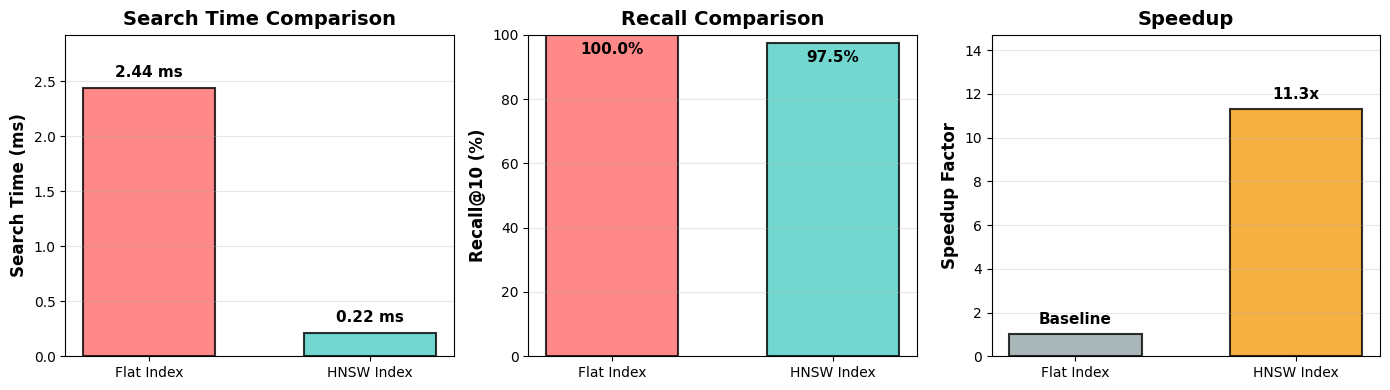


📊 FLAT vs HNSW 성능 비교 요약
  🔍 검색 속도:
     - Flat Index: 2.44 ms (Baseline)
     - HNSW Index: 0.22 ms (11.3x faster)
     - ⚡ 속도 향상: 11.3배

  ✅ 정확도:
     - Flat Index: 100.0% (Ground Truth)
     - HNSW Index: 97.5% (97.5% of optimal)

  📈 Trade-off:
     - 속도: 11.3배 향상
     - 정확도: 97.5% 유지
✓ Flat vs HNSW performance visualization completed


In [45]:
# Flat vs HNSW 성능 비교 시각화
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# 데이터 준비
indexes = ['Flat Index', 'HNSW Index']
search_times = [flat_time * 1000, hnsw_time * 1000]
recalls = [flat_recall * 100, hnsw_recall * 100]
speedups = [1.0, flat_time / hnsw_time]

# 1. 검색 시간 비교
bars1 = axes[0].bar(indexes, search_times, color=['#FF6B6B', '#4ECDC4'], alpha=0.8, edgecolor='black', linewidth=1.5, width=0.6)
axes[0].set_ylabel('Search Time (ms)', fontsize=12, fontweight='bold')
axes[0].set_title('Search Time Comparison', fontsize=14, fontweight='bold', pad=7)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim(0, max(search_times) * 1.2)

# 값 표시
for i, (bar, val) in enumerate(zip(bars1, search_times)):
    axes[0].text(bar.get_x() + bar.get_width()/2, val + max(search_times)*0.03, 
                f'{val:.2f} ms', ha='center', va='bottom', fontweight='bold', fontsize=11)

# 2. Recall 비교
bars2 = axes[1].bar(indexes, recalls, color=['#FF6B6B', '#4ECDC4'], alpha=0.8, edgecolor='black', linewidth=1.5, width=0.6)
axes[1].set_ylabel('Recall@10 (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Recall Comparison', fontsize=14, fontweight='bold', pad=7)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim(0, 100)

# 값 표시
for i, (bar, val) in enumerate(zip(bars2, recalls)):
    axes[1].text(bar.get_x() + bar.get_width()/2, val - 7, 
                f'{val:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

# 3. 속도 향상
bars3 = axes[2].bar(indexes, speedups, color=['#95A5A6', '#F39C12'], alpha=0.8, edgecolor='black', linewidth=1.5, width=0.6)
axes[2].set_ylabel('Speedup Factor', fontsize=12, fontweight='bold')
axes[2].set_title('Speedup', fontsize=14, fontweight='bold', pad=7)
axes[2].grid(True, alpha=0.3, axis='y')
axes[2].set_ylim(0, max(speedups) * 1.3)

# 값 표시
for i, (bar, val) in enumerate(zip(bars3, speedups)):
    if i == 0:
        label = 'Baseline'
    else:
        label = f'{val:.1f}x'
    axes[2].text(bar.get_x() + bar.get_width()/2, val + max(speedups)*0.03, 
                label, ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

# 요약 정보
print("\n" + "="*70)
print("📊 FLAT vs HNSW 성능 비교 요약")
print("="*70)
print(f"  🔍 검색 속도:")
print(f"     - Flat Index: {flat_time*1000:.2f} ms (Baseline)")
print(f"     - HNSW Index: {hnsw_time*1000:.2f} ms ({flat_time/hnsw_time:.1f}x faster)")
print(f"     - ⚡ 속도 향상: {flat_time/hnsw_time:.1f}배")
print(f"\n  ✅ 정확도:")
print(f"     - Flat Index: {flat_recall*100:.1f}% (Ground Truth)")
print(f"     - HNSW Index: {hnsw_recall*100:.1f}% ({hnsw_recall/flat_recall*100:.1f}% of optimal)")
print(f"\n  📈 Trade-off:")
print(f"     - 속도: {flat_time/hnsw_time:.1f}배 향상")
print(f"     - 정확도: {hnsw_recall/flat_recall*100:.1f}% 유지")
print("="*70)
print("✓ Flat vs HNSW performance visualization completed")
